In [1]:
import pystac_client  # to query the STAC catalog
import stackstac  # to form a data cube from the STAC catalog

from dask.array import nanmedian
from dask.diagnostics import ProgressBar

In [2]:
url = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(url)

bbox = [7.424160, 51.893073, 7.857380, 52.048518]

items = catalog.search(
    collections = ["sentinel-2-l2a"],
    bbox = bbox,
    datetime = ["2023-01-01T00:00:00Z", "2023-12-31T23:59:59Z"],
    query = {"eo:cloud_cover": {"lt": 30}}
).item_collection()

In [3]:
datacube = stackstac.stack(
    items,
    epsg=32632,
    assets=["red", "nir"],
    bounds_latlon=bbox
)
datacube

<xarray.DataArray 'stackstac-71b19346e85308f3bb6706e75654b17d' (time: 51,
                                                                band: 2,
                                                                y: 1785, x: 3009)> Size: 4GB
dask.array<fetch_raster_window, shape=(51, 2, 1785, 3009), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 408B 2023-...
    id                                       (time) <U24 5kB 'S2A_32UMC_20230...
  * band                                     (band) <U3 24B 'red' 'nir'
  * x                                        (x) float64 24kB 3.916e+05 ... 4...
  * y                                        (y) float64 14kB 5.768e+06 ... 5...
    s2:degraded_msi_data_percentage          (time) float64 408B 0.001 ... 0....
    ...                                       ...
    proj:shape                               object 8B {10980}
    gsd                                      int64 8B 10
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(391560.0, 5749760.0, 421650.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 391560.00|\n| 0.00,-10.00, 5767610.00|\n| 0.0...
    resolution:  10.0

In [4]:
red = datacube.sel(band="red")
nir = datacube.sel(band="nir")
ndvi = (nir-red)/(nir+red)
ndvi

<xarray.DataArray 'stackstac-71b19346e85308f3bb6706e75654b17d' (time: 51,
                                                                y: 1785, x: 3009)> Size: 2GB
dask.array<truediv, shape=(51, 1785, 3009), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 408B 2023-...
    id                                       (time) <U24 5kB 'S2A_32UMC_20230...
  * x                                        (x) float64 24kB 3.916e+05 ... 4...
  * y                                        (y) float64 14kB 5.768e+06 ... 5...
    s2:degraded_msi_data_percentage          (time) float64 408B 0.001 ... 0....
    earthsearch:payload_id                   (time) <U74 15kB 'roda-sentinel2...
    ...                                       ...
    constellation                            <U10 40B 'sentinel-2'
    s2:datatake_id                           (time) <U34 7kB 'GS2A_20230208T1...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    proj:shape                               object 8B {10980}
    gsd                                      int64 8B 10
    epsg                                     int64 8B 32632

In [5]:
resampled_ndvi = ndvi.resample({"time": "1ME"})
monthly_median_ndvi = resampled_ndvi.reduce(nanmedian, keep_attrs=True)
monthly_median_ndvi

<xarray.DataArray 'stackstac-71b19346e85308f3bb6706e75654b17d' (time: 8,
                                                                y: 1785, x: 3009)> Size: 344MB
dask.array<where, shape=(8, 1785, 3009), dtype=float64, chunksize=(1, 1022, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * x                                        (x) float64 24kB 3.916e+05 ... 4...
  * y                                        (y) float64 14kB 5.768e+06 ... 5...
  * time                                     (time) datetime64[ns] 64B 2023-0...
    instruments                              <U3 12B 'msi'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:product_type                          <U7 28B 'S2MSI2A'
    ...                                       ...
    s2:processing_baseline                   <U5 20B '05.09'
    constellation                            <U10 40B 'sentinel-2'
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    proj:shape                               object 8B {10980}
    gsd                                      int64 8B 10
    epsg                                     int64 8B 32632

[########################################] | 100% Completed | 117.68 s


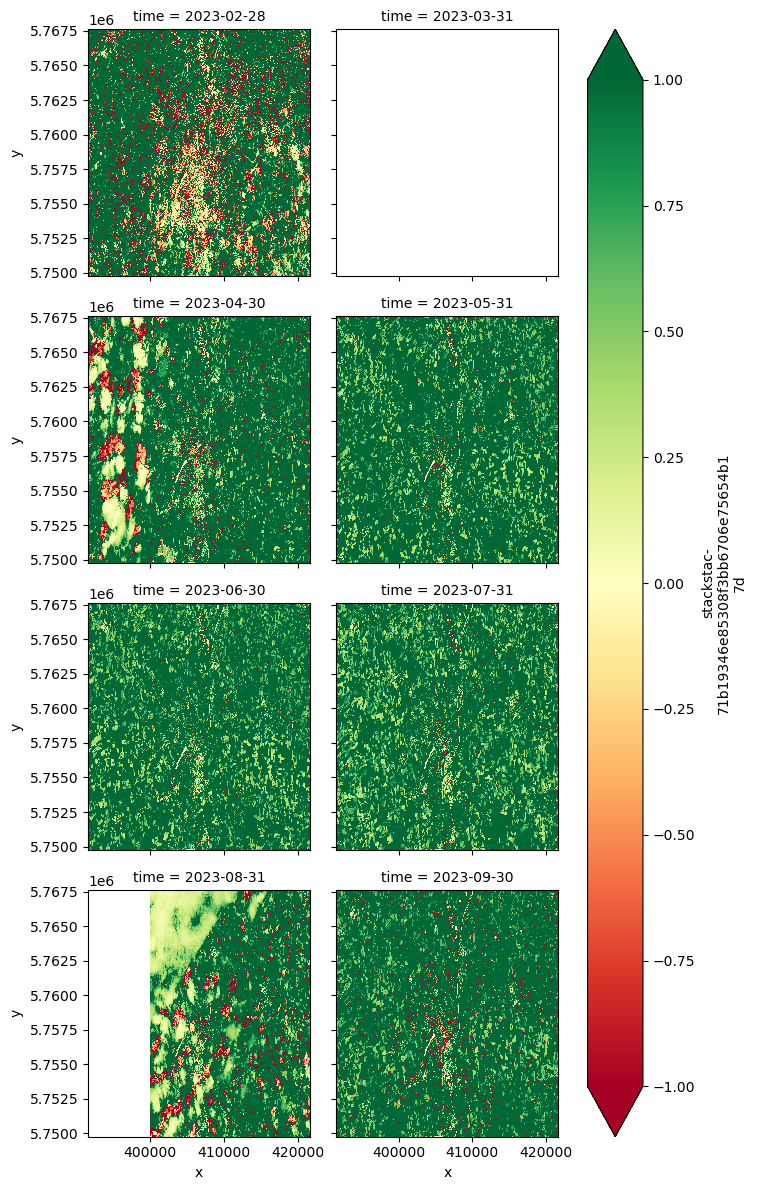

In [6]:
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# timesteps = monthly_median_ndvi.sizes["time"]
# timesteps = 2

# n_cols = 2  # Number of columns
# n_rows = math.ceil(timesteps / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
# axes = axes.ravel()

with ProgressBar():
    # for t in range(timesteps):
    #     current_month_ndvi = monthly_median_ndvi.isel(time=t)
    #     current_month_ndvi.plot(ax=axes[t], vmin=-1, vmax=1, cmap="RdYlGn")
    #     axes[t].set_title(f"Time Step {t+1}")
    monthly_median_ndvi.plot(
        col="time", col_wrap=2, vmin=-1, vmax=1, cmap="RdYlGn"
    )

 